# E3 프로젝트: 고양이 수염 스티커 만들기

## 순서 1 : 이미지 준비하기 (본인 사진images + 고양이 수염models 다운로드)

### 1. 일단 라이브러리를 가져 오자

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib

### 2. 이미지 준비는 되었는가

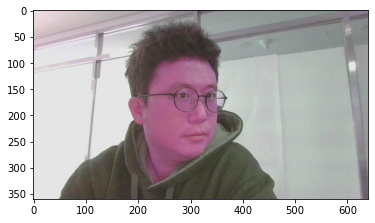

In [2]:
my_image_path = os.getenv('HOME')+'/camera_sticker/images/2021-01-12-112959.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # 도산이 처럼 RGB 이미지로 바꾸고..
plt.imshow(img_bgr)
plt.show()

역시 잘 되었군. 하지만 가끔씩 LMS 통신이 불안하여 import가 안되는 증상도 있었음.

## 순서 2 : 얼굴과 랜드마크 검출하기

오늘 배운 dlib을 이용해서 얼굴의 bounding box 위치와 landmark의 위치를 찾아 보자.

rectangles[[(218, 116) (373, 270)]]


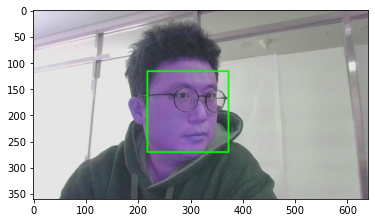

In [3]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # dlib은 rgb 이미지를 입력으로 받기 때문에 bgr 이미지를 rgb로 변환
dlib_rects = detector_hog(img_rgb, 1)   # 얼굴에 사각형 찾기
print(dlib_rects)   # 찾은 얼굴영역 좌표 숫자

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)  # 얼굴위에 사각형 표시

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

역시 잘되었군. 신기하다. 사각형이 생기다니....

## 순서 3 : 스티커 적용 위치 확인하기

고양이 수염이 적용 될 볼 위치를 landmark를 사용해서 계산.
볼은 '턱', '눈', '입', '코' 사이에 있다는 점을 이용해 주세요.
[hint] 2, 36, 48, 30 번 인덱스를 이용

In [4]:
model_path = os.getenv('HOME')+'/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print("num of landmarks : ",len(list_landmarks[0]))

num of landmarks :  68


얼굴을 일부러 비틀어 찍었는데.. 잘 될까? 랜드마크 수가 68개

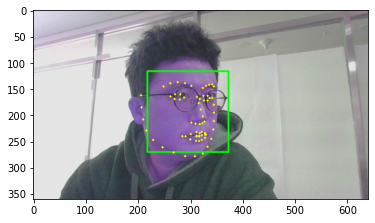

In [5]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

웃기다...

제 얼굴에서 코 중심점.. 여기다가 수염 넣어 볼까.....?

## 순서 4 : 스티커 적용하기

 (1) 오늘 배운 np.where 를 사용해서 스티커를 적용

 (2) 스티커를 조금 더 자연스럽게 보이게 하려면 어떻게 해야 할까요? 스티커 뒤로 원본 이미지가 같이 보이도록 만들어 봅시다.

    [hint] opencv 의 cv2.addWeighted() 를 참고하세요.

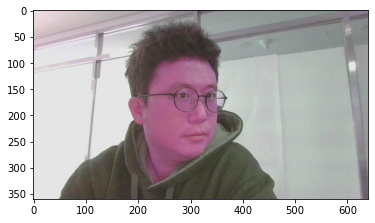

랜드마크 위치 :  (324, 202)
(x,y) : (324,124)
(w,h) : (156,156)


In [88]:
my_image_path = os.getenv('HOME')+'/camera_sticker/images/2021-01-12-112959.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # 도산이 처럼 RGB 이미지로 바꾸고..
plt.imshow(img_bgr)
plt.show()

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print ("랜드마크 위치 : ",landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]  - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

내 사진에서 코의 중심점은

In [89]:
sticker_path = os.getenv('HOME')+'/camera_sticker/models/mustache.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print ("스티커 이미지의 사이즈 : ", img_sticker.shape)

refined_x = int(x - w // 2)  # left
refined_y = int(y - h)       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

스티커 이미지의 사이즈 :  (156, 156, 3)
(x,y) : (246,-32)


코의 센터

(124, 156, 3)


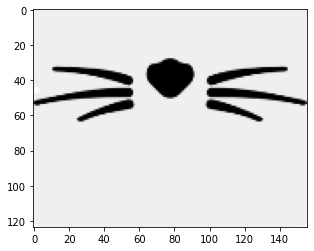

In [90]:
img_sticker = img_sticker[-refined_y:]
plt.imshow(img_sticker)

print (img_sticker.shape)

In [91]:
refined_y = 190
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (246,190)


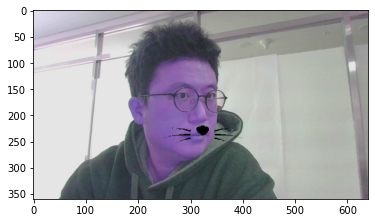

In [92]:

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
#plt.imshow(img_show)
plt.show()

앗. 얼굴의 랜드 마크에 콧수염이 머리 위에...

190
124
246
156


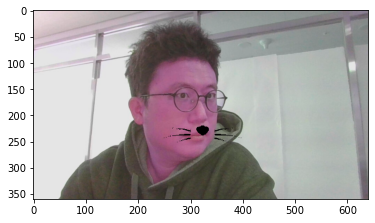

In [93]:
# sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
print(refined_y)
print(img_sticker.shape[0])
print(refined_x)
print(img_sticker.shape[1])
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

#plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.imshow(img_bgr)
plt.show()

랜드마크는 없어 졌는데 콧수염 위치랑 투명하게 만들어 봐야 겠음.

## 순서 5 : (예상)문제점 찾아 보기


    얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
    멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
    실행 속도가 중요할까요?
    스티커앱을 만들 때 정확도가 얼마나 중요할까요?


## 정리하며 : 개발자 소회

간단한 노드 같지만 숨겨져 있는 비밀들이 많은 것 같다. 기초적으로 이미지를 다루고 표현하는 방식을 많이 배웠는데..
이후 얼굴 외곽선 위에 랜드마크 크기나 분석한 정보를 텍스트로 띄우는 함수를 찾아 보려고 한다. 그리고 콧수염을 투명으로 만드는 함수도 찾아 보겠다 !!